In [9]:
import numpy as np
import pandas as pd
from lightcurve_fitting import models, filters, lightcurve
import matplotlib.pyplot as plt
import matplotlib as mpl
import importlib
import torch

# Generating fake lightcurves

In [2]:
# filters.Filter('FUV', 'b', 8, 'GALEX', filename='GALEX_GALEX.FUV.dat', angstrom=True).freq_eff
filters.filtdict["g"].freq_eff

<Quantity 648.98234254 THz>

In [3]:
lightcurve.LC({"MJD":[2,3,4],
               "mag":[16,17,18],
               "filters":[filters.filtdict["g"],filters.filtdict["g"],filters.filtdict["g"]]})
# dir(lightcurve.LC)/

MJD,mag,filters
int64,int64,object
2,16,g
3,17,g
4,18,g


In [3]:
def load_lc(lc = None, fake=True):
    if fake:
        lc =  lightcurve.LC({"MJD":[2,3,4],
                "mag":[16,17,18],
                "filters":[filters.filtdict["g"],filters.filtdict["g"],filters.filtdict["g"]]})

    lc.meta['dm'] = 31.39
    lc.meta['extinction'] = {
    'U_S': 0.125,
    'B_S':0.103,
    'V_S':0.082,
    'U': 0.131,
    'B': 0.109,
    'V': 0.083,
    'R': 0.065,
    'I': 0.045,
    'u': 0.128,
    'g': 0.100,
    'c': 0.085,
    'r': 0.069,
    'o': 0.060,
    'i': 0.051,
    'z': 0.038,
    'UVW2': 0.234,
    'UVM2': 0.211,
    'UVW1': 0.166,
    'DLT40': 0.083,
    }
    # Based on no Na I D detection in spectrum
    lc.meta['hostext'] = {
    'U': 0.,
    'B': 0.,
    'V': 0.,
    'R': 0.,
    'I': 0.,
    'u': 0.,
    'g': 0.,
    'r': 0.,
    'i': 0.,
    'z': 0.,
    'UVW2': 0.,
    'UVM2': 0.,
    'UVW1': 0.,
    'o': 0.,
    'c': 0.,
    'U_S': 0.,
    'B_S': 0.,
    'V_S': 0.,
    'DLT40': 0.,
    }

    z = 0.00526
    lc.meta['redshift'] = z  # redshift
    return lc


In [37]:
filters.filtdict["uvw1"].freq_eff

<Quantity 1236.85275455 THz>

In [39]:
model.input_names

['v_\\mathrm{s*}', 'M_\\mathrm{env}', 'f_\\rho M', 'R', 't_0']

In [4]:
lc_fake = load_lc(fake=True)
model = models.ShockCooling4(lc_fake)


MJD = np.linspace(3, 13, 300)
filters_list = [filters.filtdict["g"],filters.filtdict["uvw1"], filters.filtdict["r"], filters.filtdict["i"], filters.filtdict["z"]]
filter_for_mjd = np.random.choice(filters_list, size=len(MJD), replace=True)

ten13cmtoRsol = 1e13*1.4374e-11
ten8p5cmstoten3kms = 10**.5
units_array = np.array([ten8p5cmstoten3kms, 1, 1, ten13cmtoRsol, 1])
model_inputs = np.array([7.2, 5, 1.6, 410, 2.5])/units_array



In [5]:
v_s = model_inputs[0]       # Shock velocity
M_env = model_inputs[1]     # Envelope mass
f_rho_M = model_inputs[2]   # Density profile factor
R = model_inputs[3]         # Radius
t_exp = model_inputs[4]     # explosion time

lum = model(MJD, v_s=v_s, M_env=M_env, f_rho_M=f_rho_M, R=R, t_exp=t_exp, f=filter_for_mjd)

In [6]:
lc = load_lc(lc=lightcurve.LC({"MJD":MJD,
                "lum":lum,
                "dlum":np.random.normal(1e9, 1e6, len(lum)),
                "filter":filter_for_mjd}),
                fake=False)
lc

MJD,lum,dlum,filter
float64,float64,float64,object
3.0,2.2092766000989687e+20,1000417848.5746455,g
3.0334448160535117,1.0748757851952982e+20,998352345.2563902,i
3.0668896321070234,1.1334311042243363e+20,998758085.075783,i
3.100334448160535,1.1914222419152973e+20,1001018103.0570688,i
3.1337792642140467,1.2488502002390601e+20,1000942307.3536423,i
3.1672240802675584,1.798321467937378e+20,1000960479.1661866,r
3.20066889632107,1.3620266310264272e+20,1001507977.8337046,i
3.234113712374582,1.9462788169887367e+20,999276857.1521293,r
3.2675585284280935,2.0188624642118677e+20,1000099260.4790686,r


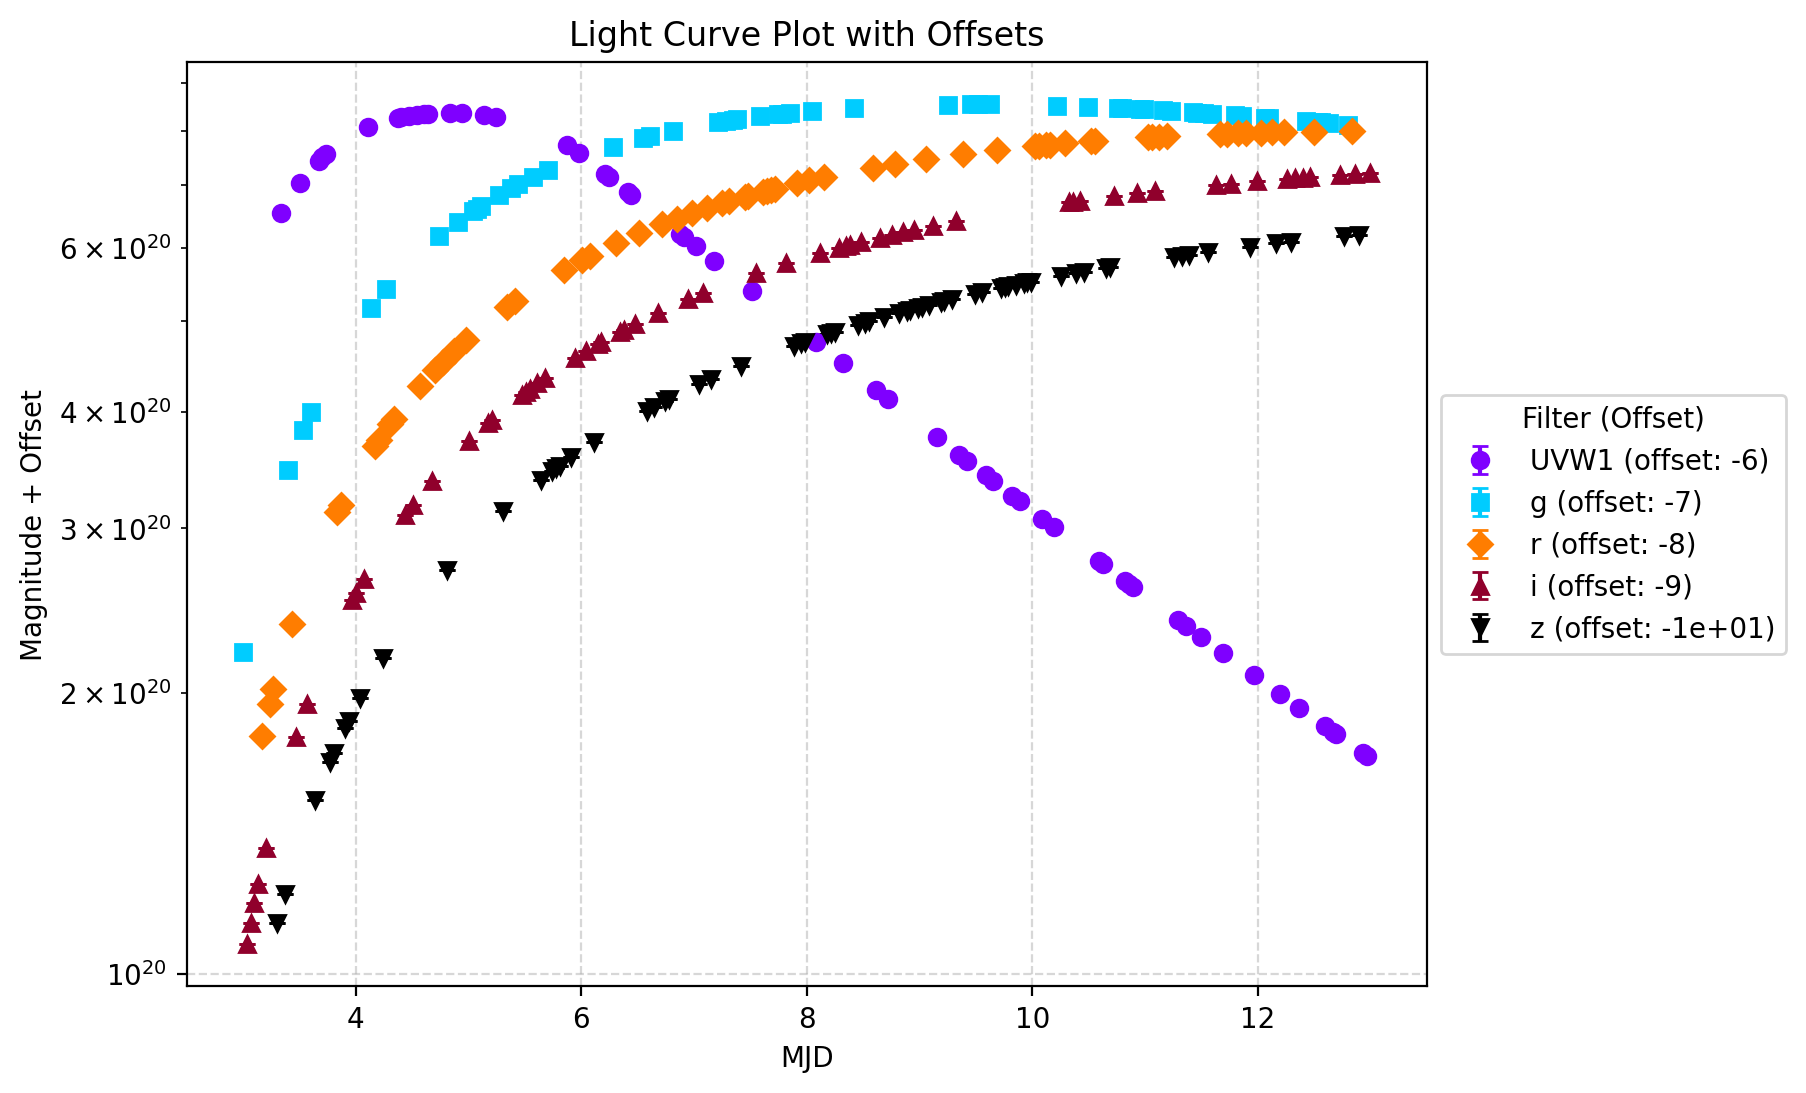

In [7]:
import numpy as np
import matplotlib.pyplot as ax

def light_curve_plot(lc, offset=0.5):
    """
    Plots light curves with different markers, applying an offset for each filter.
    
    Parameters:
    lc : dict or structured array
        A dataset containing 'MJD', 'mag', 'dmag', and 'filter' fields.
    """

    # Unique filters in the dataset
    ufilts = np.unique(lc['filter'])

    # Define marker styles for each filter
    markers = ['o', 's', 'D', '^', 'v', 'P', '*', 'X']
    face_color = []
    
    # Define offsets for each filter (spaced by 0.5 mag)
    offsets = {filt: -10 + i * offset for i, filt in enumerate(ufilts[::-1])}

    fig, ax = plt.subplots(figsize=(8, 6), dpi=200)  # Set figure size

    for i, filt in enumerate(ufilts):
        # Create mask for the current filter
        fmask = np.array(lc['filter'] == filt)
        
        # Extract values and apply offset
        mjd_filt = lc['MJD'][fmask]
        y_filt = lc['lum'][fmask] + offsets[filt]  # Apply offset
        y_filt_err = lc['dlum'][fmask]
        
        # Select marker style based on index
        marker = markers[i % len(markers)]
        
        style = filt.plotstyle

        # Plot with error bars
        ax.errorbar(mjd_filt, y_filt, yerr=y_filt_err,
         fmt=marker, label=f"{filt} (offset: {offsets[filt]:.1g})",
         capsize=3, **style)

    # Aesthetics
    ax.set_xlabel("MJD")
    ax.set_ylabel("Magnitude + Offset")
    # ax.invert_yaxis()  # Invert y-axis for magnitudes
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_title("Light Curve Plot with Offsets")
    ax.set_yscale("log")
    # Move the legend to the right of the plot
    ax.legend(title="Filter (Offset)", loc='center left', bbox_to_anchor=(1, 0.5))

        
# light_curve_plot(lc)
light_curve_plot(lc, offset = 1)

# Preparing to PILCA

In [10]:
MJD_TO_MODEL = MJD
LUM_TO_MODEL = np.log10(lc["lum"])
DLUM_TO_MODEL = lc["dlum"]/lc["lum"]/np.log(10)
X_DATA = np.hstack([MJD_TO_MODEL.reshape(-1,1), LUM_TO_MODEL.reshape(-1,1), DLUM_TO_MODEL.reshape(-1,1)])
ufilters = np.unique(lc["filter"])
filters_mask = torch.zeros((len(ufilters),len(lc)), requires_grad=False, dtype=torch.int)
for i in range(len(ufilters)):
    filters_mask[i] = torch.tensor(lc["filter"]==ufilters[i])

In [11]:
X_DATA = torch.tensor(X_DATA, requires_grad=False)

In [12]:
import torch
print(torch.cuda.is_available())
# device = 'gpu:0'
device = 'cpu'


True


In [121]:
torch.tensor([2.2768, 5.0000, 1.6000, 2.8524, 2.5000], dtype=torch.float64)

tensor([2.2768, 5.0000, 1.6000, 2.8524, 2.5000], dtype=torch.float64)

In [13]:
importlib.reload(models)
lc_fake = load_lc(fake=True)
model_original = models.ShockCooling4(lc_fake)

ten13cmtoRsol = 1e13*1.4374e-11

ten8p5cmstoten3kms = 10**.5
units_array = np.array([ten8p5cmstoten3kms, 1, 1, ten13cmtoRsol, 1])
model_inputs = np.array([7.2, 5, 1.6, 410, 2.5])/units_array
v_s = model_inputs[0]       # Shock velocity
M_env = model_inputs[1]     # Envelope mass
f_rho_M = model_inputs[2]   # Density profile factor
R = model_inputs[3]         # Radius
t_exp = model_inputs[4]     # explosion time

lum = model_original(MJD[0:], v_s=v_s, M_env=M_env, f_rho_M=f_rho_M, R=R, t_exp=t_exp, f=[filter_for_mjd[0]])
lum_original = lum

In [14]:
importlib.reload(tp)
model_inputs_torch = torch.tensor([7.2, 5, 1.6, 410, 2.5])/units_array

v_s = model_inputs_torch[0]       # Shock velocity
M_env = model_inputs_torch[1]     # Envelope mass
f_rho_M = model_inputs_torch[2]   # Density profile factor
R = model_inputs_torch[3]         # Radius
t_exp = model_inputs_torch[4]     # explosion time
model_torch = tp.ShockCooling4(z=lc.meta["redshift"])
lum= model_torch(MJD[:], v_s=v_s, M_env=M_env, f_rho_M=f_rho_M, R=R, t_exp=t_exp, f=filter_for_mjd[0])
lum_torch = lum

In [16]:
torch.sqrt(torch.sum((torch.tensor(lum_original) - lum_torch)**2))/len(lum_original)
# torch.log10(lum_torch)-np.log10(lum_original)

tensor(1.6252e+15, dtype=torch.float64)

In [17]:
model_inputs_torch = torch.tensor([7.2, 5, 1.6, 410, 2.5])/units_array

v_s = model_inputs_torch[0]       # Shock velocity
M_env = model_inputs_torch[1]     # Envelope mass
f_rho_M = model_inputs_torch[2]   # Density profile factor
R = model_inputs_torch[3]         # Radius
t_exp = model_inputs_torch[4]     # explosion time
model = tp.ShockCooling4(z=lc.meta["redshift"])
for f in np.unique(filter_for_mjd):
    mask = filter_for_mjd == f
    y = model(MJD[mask], v_s=v_s, M_env=M_env, f_rho_M=f_rho_M, R=R, t_exp=t_exp, f=f)
    print(y)

tensor([6.5315e+20, 7.0413e+20, 7.4365e+20, 7.5038e+20, 7.5675e+20, 8.0722e+20,
        8.2635e+20, 8.2794e+20, 8.3065e+20, 8.3277e+20, 8.3436e+20, 8.3496e+20,
        8.3613e+20, 8.3534e+20, 8.3145e+20, 8.2850e+20, 7.7352e+20, 7.5710e+20,
        7.1972e+20, 7.1450e+20, 6.8882e+20, 6.8377e+20, 6.2108e+20, 6.1648e+20,
        6.0288e+20, 5.8085e+20, 5.3915e+20, 4.7518e+20, 4.5121e+20, 4.2230e+20,
        4.1311e+20, 3.7577e+20, 3.5980e+20, 3.5465e+20, 3.4212e+20, 3.3725e+20,
        3.2541e+20, 3.2080e+20, 3.0742e+20, 3.0097e+20, 2.7664e+20, 2.7471e+20,
        2.6348e+20, 2.6166e+20, 2.5985e+20, 2.3924e+20, 2.3599e+20, 2.2964e+20,
        2.2048e+20, 2.0890e+20, 1.9934e+20, 1.9282e+20, 1.8410e+20, 1.8169e+20,
        1.8050e+20, 1.7241e+20, 1.7129e+20], dtype=torch.float64)
tensor([2.2093e+20, 3.4637e+20, 3.8245e+20, 3.9955e+20, 5.1708e+20, 5.4183e+20,
        6.1665e+20, 6.3948e+20, 6.5644e+20, 6.6051e+20, 6.6451e+20, 6.8356e+20,
        6.9426e+20, 7.0110e+20, 7.1412e+20, 7.2629e+20

In [225]:
mask = filter_for_mjd == f


In [18]:
import torchphysics as tp
importlib.reload(tp)
model = tp.ShockCooling4(z=lc.meta["redshift"])

pilcas = []
# fig, ax = plt.subplots(figsize=(8, 6), dpi=200)

for i, f in enumerate(np.unique(filter_for_mjd)):
    mask = filter_for_mjd == f
    print(np.sum(mask), np.sum(lc["filter"]==f), np.sum(filters_mask.detach().numpy()[i]))
    y = model(MJD[mask], v_s=v_s, M_env=M_env, f_rho_M=f_rho_M, R=R, t_exp=t_exp, f=f)
    # print(len(y), np.sum(mask))
    # ax.plot(MJD[mask], y)
    pilcas.append(y)
len(MJD), len(lc["MJD"]), np.sum(np.array(lc["filter"])==np.unique(filter_for_mjd)[0])

57 57 57
55 55 55
62 62 62
60 60 60
66 66 66


(300, 300, 57)

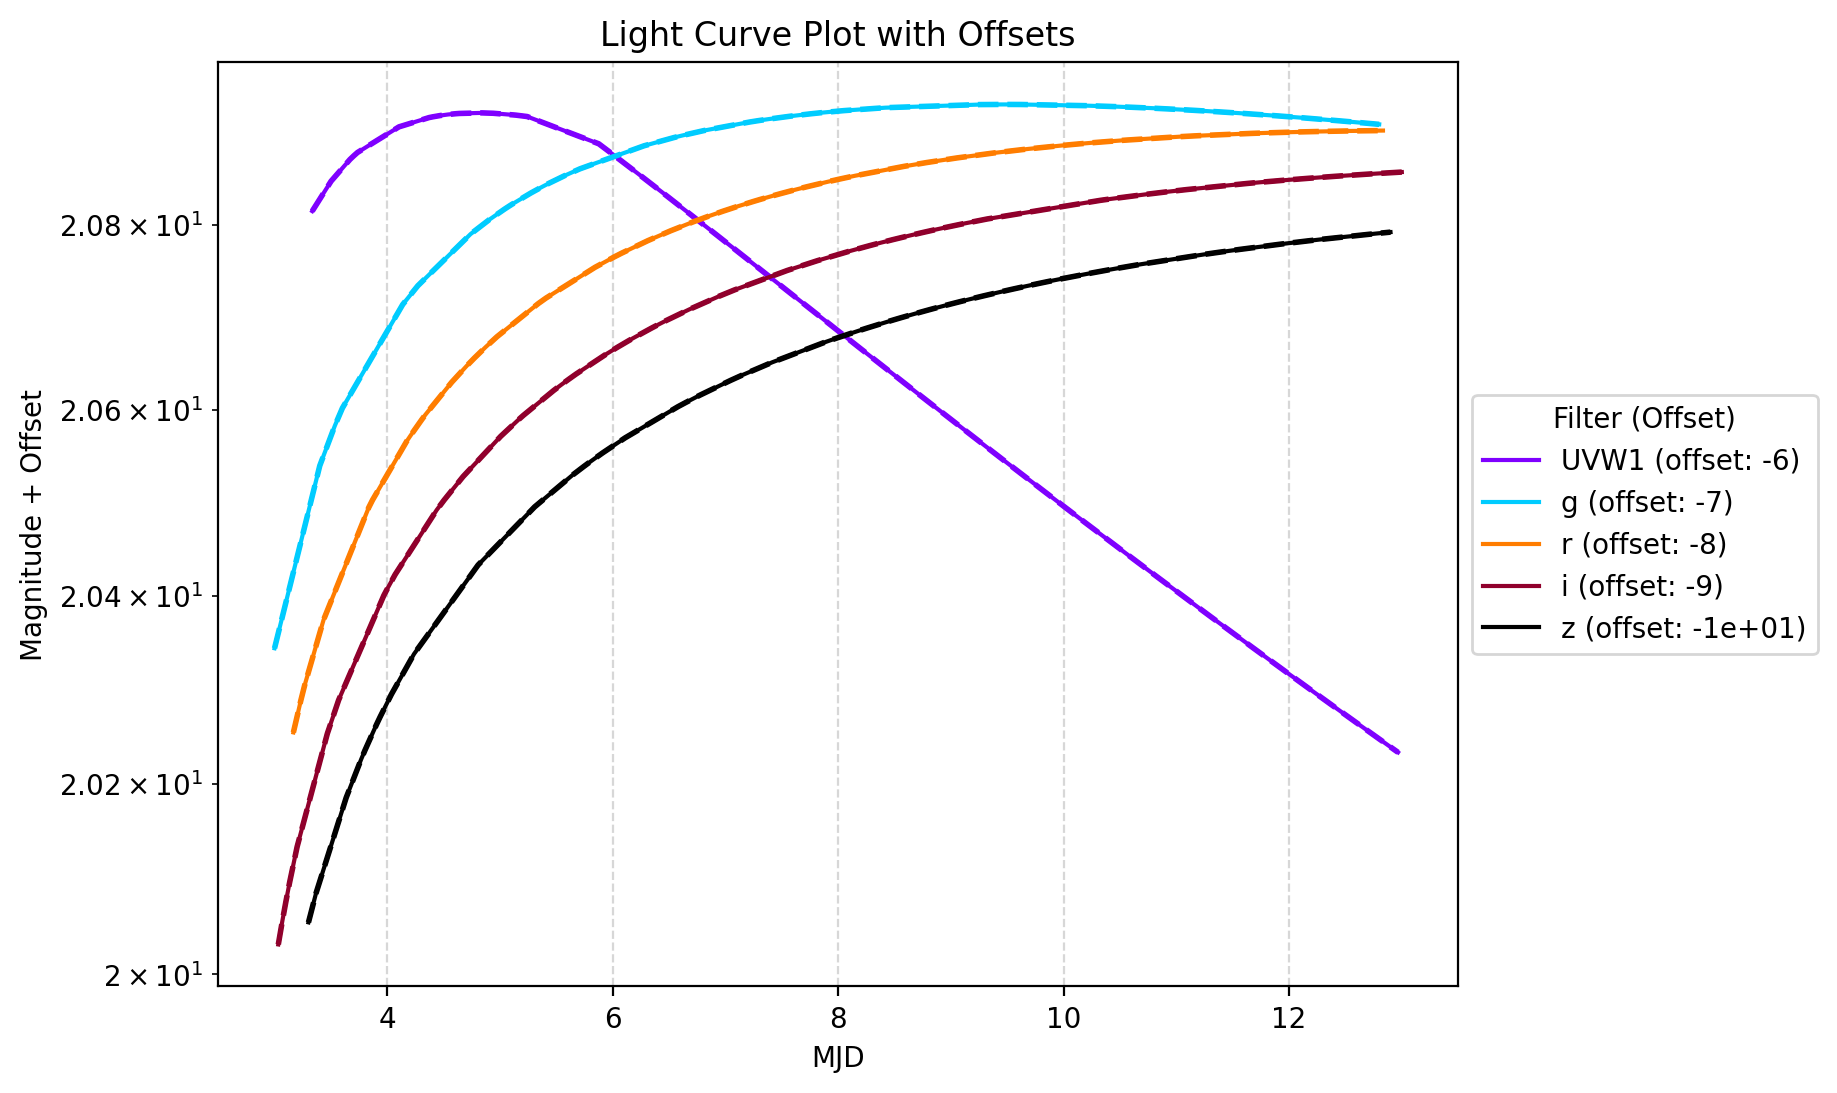

In [19]:
import numpy as np
import matplotlib.pyplot as ax

def light_curve_plot(lc, offset=0.5, pilcas=None, ufilters=None):
    """
    Plots light curves with different markers, applying an offset for each filter.
    
    Parameters:
    lc : dict or structured array
        A dataset containing 'MJD', 'mag', 'dmag', and 'filter' fields.
    """

    # Unique filters in the dataset
    ufilts = ufilters#np.unique(lc['filter'])

    # Define marker styles for each filter
    markers = ['o', 's', 'D', '^', 'v', 'P', '*', 'X']
    face_color = []
    
    # Define offsets for each filter (spaced by 0.5 mag)
    offsets = {filt: -10 + i * offset for i, filt in enumerate(ufilts[::-1])}

    fig, ax = plt.subplots(figsize=(8, 6), dpi=200)  # Set figure size

    for i, filt in enumerate(ufilts):
        # Create mask for the current filter
        fmask = np.array(lc['filter'] == filt)
        
        # Extract values and apply offset
        mjd_filt = lc['MJD'][fmask]
        y_filt = lc['lum'][fmask] + offsets[filt]  # Apply offset
        y_filt_err = lc['dlum'][fmask]
        if pilcas:
            y_pilca = pilcas[i]
        # Select marker style based on index
        marker = markers[i % len(markers)]
        
        style = filt.plotstyle

        # Plot with error bars
        # ax.errorbar(mjd_filt, y_filt, yerr=y_filt_err,
        #  fmt=marker, label=f"{filt} (offset: {offsets[filt]:.1g})",
        #  capsize=3, **style)
        ax.plot(mjd_filt, np.log10(y_filt), 
         ls="-", label=f"{filt} (offset: {offsets[filt]:.1g})", **style)
        # print(filt)
        # aaa
        ax.plot(mjd_filt, torch.log10(y_pilca), c=style["mfc"], lw=2, ls="--")

    # Aesthetics
    ax.set_xlabel("MJD")
    ax.set_ylabel("Magnitude + Offset")
    # ax.invert_yaxis()  # Invert y-axis for magnitudes
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_title("Light Curve Plot with Offsets")
    ax.set_yscale("log")
    # Move the legend to the right of the plot
    ax.legend(title="Filter (Offset)", loc='center left', bbox_to_anchor=(1, 0.5))

        
# light_curve_plot(lc)
light_curve_plot(lc, offset = 1, pilcas=pilcas, ufilters=np.unique(filter_for_mjd))

In [20]:
import torch.nn as nn

class SC4Loss(nn.Module):
    def __init__(self, sc4model, ufilters):
        """
        Custom Weighted Mean Squared Error Loss
        :param weight: A tensor of weights for each sample (optional).
        """
        super(SC4Loss, self).__init__()
        self.sc4model = sc4model
        self.ufilters = ufilters
        # self.weight = weight

    def forward(self, outputs, targets, filters_mask):
        """
        Compute the weighted MSE loss.
        :param predictions: Model outputs (torch tensor).
        :param targets: Ground truth values (torch tensor).
        :return: Weighted MSE loss value.
        """
        v_s = outputs[0]       # Shock velocity
        M_env = outputs[1]     # Envelope mass
        f_rho_M = outputs[2]   # Density profile factor
        R = outputs[3]         # Radius
        t_exp = outputs[4] 
        # sigma = outputs[5] 
        loss = 0
        for i, f in enumerate(self.ufilters):
            print(f)
            lum = self.sc4model(targets[:,0][filters_mask[i]], v_s=v_s, M_env=M_env, f_rho_M=f_rho_M, R=R, t_exp=t_exp, f=f)
            # print(lum)
            # print(lum)
            # aa

            y_fit = torch.log10(lum)
            y = targets[:,1][filters_mask[i]]
            print(y[6], y_fit[6])
            # a
            loss += (torch.sum((y-y_fit)**2)/len(y_fit))

        return loss.mean()

In [654]:

param_dim = 5
k_layers = 3
base_distribution = distributions.StandardNormal(shape=[param_dim])
transform_list = []
for _ in range(k_layers):
    transform_list.append(transforms.MaskedAffineAutoregressiveTransform(features=param_dim, hidden_features=10))
# transform_list.append(SoftplusTransform())

transform = transforms.CompositeTransform(transform_list)
model = flows.Flow(transform, base_distribution)



In [656]:
import torchphysics as tp
importlib.reload(tp)
# model_inputs_torch = torch.tensor([7.2, 5, 1.6, 410, 2.5])/units_array
lr=1e-4
optimizer = torch.optim.Adam(flow_model.parameters(), lr=lr)
sc4model = tp.ShockCooling4(z=lc.meta["redshift"])
criterion = SC4Loss(sc4model, ufilters=ufilters)
epochs = 1
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model.sample(1)
    outputs = nn.functional.softplus(outputs)#model_inputs_torch#torch.clamp(outputs, 1)
    
    print(outputs)
    loss = criterion(outputs.squeeze(), X_DATA, filters_mask)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")


tensor([[7.3935e-01, 1.9063e+00, 3.4004e-02, 3.3599e-05, 7.6117e-03]],
       grad_fn=<SoftplusBackward0>)
UVW1
tensor(20.3443, dtype=torch.float64) tensor(nan, dtype=torch.float64, grad_fn=<SelectBackward0>)
g
tensor(20.3443, dtype=torch.float64) tensor(nan, dtype=torch.float64, grad_fn=<SelectBackward0>)
r
tensor(20.3443, dtype=torch.float64) tensor(nan, dtype=torch.float64, grad_fn=<SelectBackward0>)
i
tensor(20.0314, dtype=torch.float64) tensor(nan, dtype=torch.float64, grad_fn=<SelectBackward0>)
z
tensor(20.3443, dtype=torch.float64) tensor(nan, dtype=torch.float64, grad_fn=<SelectBackward0>)
Epoch 0: Loss = nan


In [ ]:


model = tp.ShockCooling4(z=lc.meta["redshift"])
loss = SC4Loss(sc4model=model, ufilters=ufilters)
loss(outputs=torch.tensor([7.2, 5, 1.6, 410, 2.5])/units_array, targets=X_DATA, filters_mask=filters_mask)

In [49]:
from nflows import transforms, distributions, flows

# Define an invertible transformation.
transform = transforms.CompositeTransform([
    transforms.MaskedAffineAutoregressiveTransform(features=2, hidden_features=4),
    transforms.RandomPermutation(features=2)
])

# Define a base distribution.
base_distribution = distributions.StandardNormal(shape=[2])


# Combine into a flow.
flow = flows.Flow(transform=transform, distribution=base_distribution)

In [53]:
flow.sample(2)

tensor([[-1.3946, -0.3423],
        [ 0.7124, -0.4969]], grad_fn=<DivBackward0>)

In [95]:
import torch
import torch.nn as nn
import torch.optim as optim
import nflows.transforms as transforms
import nflows.distributions as distributions
import nflows.flows as flows

# Generate synthetic positive data
def generate_synthetic_data(n_samples=1000, dim=5):
    """Generates synthetic data with strictly positive values."""
    return torch.exp(torch.randn(n_samples, dim))  # Exponentiated normal for positivity

class SigmoidTransform(transforms.Transform):
    def __init__(self, lower_bound=1e-3, upper_bound=10.0):
        super().__init__()
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound

    def forward(self, inputs, context=None):
        """Transforms input to be within [lower_bound, upper_bound] using sigmoid scaling."""
        outputs = self.lower_bound + (self.upper_bound - self.lower_bound) * torch.sigmoid(inputs)
        logabsdet = torch.log((self.upper_bound - self.lower_bound) * torch.sigmoid(inputs) * (1 - torch.sigmoid(inputs)))
        return outputs, torch.sum(logabsdet, dim=-1)

    def inverse(self, inputs, context=None):
        """Inverse transform using logit scaling."""
        inputs = torch.clamp(inputs, self.lower_bound + 1e-6, self.upper_bound - 1e-6)  # Prevent log(0)
        outputs = torch.log((inputs - self.lower_bound) / (self.upper_bound - inputs))
        logabsdet = -torch.log((inputs - self.lower_bound) * (self.upper_bound - inputs))
        return outputs, torch.sum(logabsdet, dim=-1)#.sum(dim=-1, keepdim=True)


# Define a normalizing flow model with K transformation layers
def create_flow_model(k_layers=5, param_dim=5):
    base_distribution = distributions.StandardNormal(shape=[param_dim])
    transform_list = []
    for _ in range(k_layers):
        transform_list.append(transforms.MaskedAffineAutoregressiveTransform(features=param_dim, hidden_features=10))
    transform_list.append(SigmoidTransform())  # Ensure positive outputs
    
    transform = transforms.CompositeTransform(transform_list)
    return flows.Flow(transform, base_distribution)

# Custom loss function
def custom_loss_function(log_prob):
    return -log_prob.mean()

# Training function
def train_flow(model, data, epochs=1000, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        log_prob = model.log_prob(data)
        loss = custom_loss_function(log_prob)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

# Generate training data with 5 positive parameters
data = generate_synthetic_data(n_samples=1000, dim=5)

# Create and train the flow model with K layers
K = 5  # Number of transformation layers
param_dim = 5  # Number of output parameters
flow_model = create_flow_model(K, param_dim)
train_flow(flow_model, data)

# Sample from the trained model
N = 10  # Number of samples
samples = flow_model.sample(num_samples=1)
print("Generated Samples:", samples)


Epoch 0: Loss = 90.9142
Epoch 100: Loss = 29.6444
Epoch 200: Loss = 24.4131
Epoch 300: Loss = 21.9954
Epoch 400: Loss = 19.8965
Epoch 500: Loss = 18.2527


KeyboardInterrupt: 

In [436]:
import torch
import normflows as nf

class ExpTransform(nf.transforms.Transform):
    """Elementwise exponential transform to ensure positive outputs."""
    def __init__(self):
        super().__init__()

    def forward(self, z):
        x = torch.exp(z)
        log_det = torch.sum(z, dim=1)  # log|det(Jacobian)| = sum(z)
        return x, log_det

    def inverse(self, x):
        z = torch.log(x)
        log_det = -torch.sum(z, dim=1)  # log|det(Jacobian)| = -sum(log(x))
        return z, log_det

# Define the dimensionality of your parameters
param_dim = 5

# Define the base distribution
base = nf.distributions.DiagGaussian(param_dim)

# Define the sequence of transformations
transforms = []
for _ in range(3):  # Number of layers
    transforms.append(nf.transforms.MaskedAffineAutoregressiveTransform(param_dim, param_dim))
transforms.append(ExpTransform())  # Ensure positivity

# Combine transformations into a normalizing flow model
flow = nf.NormalizingFlow(base, transforms)

# Sample from the model
samples = flow.sample(2)
print(samples)

AttributeError: module 'normflows.transforms' has no attribute 'Transform'

In [480]:
torch.nn.functional.softplus(torch.tensor(-54.))

tensor(3.5326e-24)

In [490]:
base_distribution.sample(489451).flatten()

tensor([0.9668, 0.1584, 1.2892,  ..., 0.2196, 0.6326, 0.3509])

(array([12., 23., 40., 29., 25.,  9.,  8.,  1.,  2.,  1.]),
 array([0.08203599, 0.25807101, 0.43410605, 0.61014104, 0.78617609,
        0.96221113, 1.13824618, 1.31428123, 1.49031615, 1.6663512 ,
        1.84238625]),
 <BarContainer object of 10 artists>)

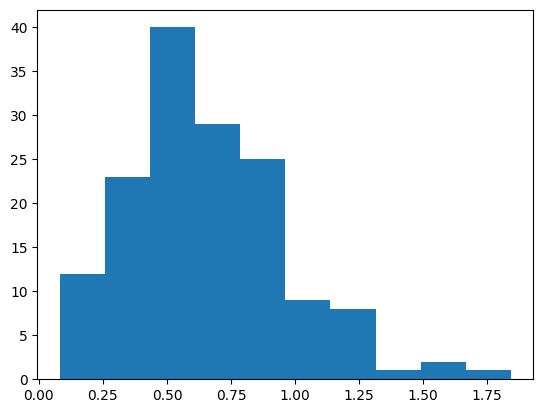

In [514]:
plt.hist(torch.nn.functional.softplus(transforms.MaskedAffineAutoregressiveTransform(features=param_dim, hidden_features=10)(base_distribution.sample(30))[0].flatten()).detach().numpy())

In [637]:

import torch
from nflows import transforms, distributions, flows


class SoftplusTransform(transforms.Transform):
    """Elementwise softplus transform to ensure positive outputs."""
    def forward(self, inputs, context=None):
        outputs = torch.nn.functional.softplus(inputs)
        logabsdet = torch.sum(torch.log1p(torch.exp(-inputs)), dim=-1)
        print(inputs)
        print("AAAA")
        return outputs, logabsdet

    def inverse(self, inputs, context=None):
        outputs = torch.log(torch.expm1(inputs))
        logabsdet = -torch.sum(torch.log1p(torch.exp(-outputs)), dim=-1)
        print(inputs)
        return outputs, logabsdet

# Define the dimensionality of your parameters
param_dim = 5

# Define the base distribution
base_distribution = distributions.StandardNormal(shape=[param_dim])

# Define the sequence of transformations
transform_list = []
for _ in range(2):  # Number of layers
    transform_list.append(transforms.MaskedAffineAutoregressiveTransform(features=param_dim, hidden_features=10))
# transform_list.append(SoftplusTransform())  # Ensure positivity

# Combine transformations into a composite transform
transform = transforms.CompositeTransform(transform_list)

# Create the flow model
model = flows.Flow(transform, base_distribution)

# Sample from the model
samples = model.sample(num_samples=1)
print(samples)

tensor([[-3.2473,  2.7183, -3.2162,  0.9288, -0.2016]], grad_fn=<DivBackward0>)
